# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Import libraries
import numpy as np
import pandas as pd

In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%age)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [3]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = len(student_data)
n_features = len(student_data.columns)
n_passed = student_data[student_data['passed'] == 'yes'].count()['passed']
n_failed = student_data[student_data['passed'] == 'no'].count()['passed']
grad_rate = (float(n_passed) / float(n_students)) * 100
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 31
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [5]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [6]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=num_train, random_state=0)
# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What is the theoretical O(n) time & space complexity in terms of input size?
- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [7]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

In [8]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')

In [17]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    f1_training = predict_labels(clf, X_train, y_train)
    f1_test = predict_labels(clf, X_test, y_test)
    print "F1 score for training set: {}".format(f1_training)
    print "F1 score for test set: {}".format(f1_test)
    return clf.__class__.__name__, len(X_train), f1_training, f1_test

In [32]:
# variable to store F1 scores
scores = []

In [33]:
# model 1 :: logistic regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1000.0, random_state=0)

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# Training set sizes = 100
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=100, random_state=0)
scores.append(train_predict(clf, X_train, y_train, X_test, y_test))

# Training set sizes = 200
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=200, random_state=0)
scores.append(train_predict(clf, X_train, y_train, X_test, y_test))

# Training set sizes = 300
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=300, random_state=0)
scores.append(train_predict(clf, X_train, y_train, X_test, y_test))
print '#############################################################################################'

Training LogisticRegression...
Done!
Training time (secs): 0.007
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.839285714286
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.764705882353
------------------------------------------
Training set size: 100
Training LogisticRegression...
Done!
Training time (secs): 0.007
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.001
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.993197278912
F1 score for test set: 0.621468926554
------------------------------------------
Training set size: 200
Training LogisticRegression...
Done!
Training time (secs): 0.004
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training

In [34]:
# model 2 :: SVM (linear)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

from sklearn.svm import SVC
clf = SVC(kernel='linear', C=1.0, random_state=0)

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# Training set sizes = 100
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=100, random_state=0)
sc.fit(X_train)
X_train = sc.transform(X_train)
train_predict(clf, X_train, y_train, X_test, y_test)

# Training set sizes = 200
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=200, random_state=0)
sc.fit(X_train)
X_train = sc.transform(X_train)
train_predict(clf, X_train, y_train, X_test, y_test)

# Training set sizes = 300
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=300, random_state=0)
sc.fit(X_train)
X_train = sc.transform(X_train)
train_predict(clf, X_train, y_train, X_test, y_test)
print '#############################################################################################'

Training SVC...
Done!
Training time (secs): 0.088
Predicting labels using SVC...
Done!
Prediction time (secs): 0.004
F1 score for training set: 0.848351648352
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.785714285714
------------------------------------------
Training set size: 100
Training SVC...
Done!
Training time (secs): 0.004
Predicting labels using SVC...
Done!
Prediction time (secs): 0.000
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.96
F1 score for test set: 0.0103626943005
------------------------------------------
Training set size: 200
Training SVC...
Done!
Training time (secs): 0.017
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.88
F1 score for test set: 0.0
------------------------------------------
Training set size: 300
Training SVC...
Done!
Training time (sec

In [35]:
# model 2 :: SVM (kernel)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=1.0, random_state=0)

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# Training set sizes = 100
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=100, random_state=0)
sc.fit(X_train)
X_train = sc.transform(X_train)
scores.append(train_predict(clf, X_train, y_train, X_test, y_test))

# Training set sizes = 200
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=200, random_state=0)
sc.fit(X_train)
X_train = sc.transform(X_train)
scores.append(train_predict(clf, X_train, y_train, X_test, y_test))

# Training set sizes = 300
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=300, random_state=0)
sc.fit(X_train)
X_train = sc.transform(X_train)
scores.append(train_predict(clf, X_train, y_train, X_test, y_test))
print '#############################################################################################'

Training SVC...
Done!
Training time (secs): 0.011
Predicting labels using SVC...
Done!
Prediction time (secs): 0.011
F1 score for training set: 0.907079646018
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for test set: 0.766233766234
------------------------------------------
Training set size: 100
Training SVC...
Done!
Training time (secs): 0.002
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for training set: 0.929936305732
F1 score for test set: 0.788501026694
------------------------------------------
Training set size: 200
Training SVC...
Done!
Training time (secs): 0.007
Predicting labels using SVC...
Done!
Prediction time (secs): 0.004
Predicting labels using SVC...
Done!
Prediction time (secs): 0.004
F1 score for training set: 0.910256410256
F1 score for test set: 0.77358490566
------------------------------------------
Training set size: 300
Training SV

In [36]:
# model 3 :: Decision tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# Training set sizes = 100
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=100, random_state=0)
scores.append(train_predict(clf, X_train, y_train, X_test, y_test))

# Training set sizes = 200
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=200, random_state=0)
scores.append(train_predict(clf, X_train, y_train, X_test, y_test))

# Training set sizes = 300
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=300, random_state=0)
scores.append(train_predict(clf, X_train, y_train, X_test, y_test))

Training DecisionTreeClassifier...
Done!
Training time (secs): 0.002
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.83257918552
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.588235294118
------------------------------------------
Training set size: 100
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.002
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.001
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.884848484848
F1 score for test set: 0.799107142857
------------------------------------------
Training set size: 200
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.001
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.001
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time 

In [37]:
scores

[('LogisticRegression', 100, 0.99319727891156473, 0.62146892655367225),
 ('LogisticRegression', 200, 0.87625418060200677, 0.75486381322957197),
 ('LogisticRegression', 300, 0.83928571428571419, 0.76470588235294112),
 ('SVC', 100, 0.92993630573248409, 0.78850102669404509),
 ('SVC', 200, 0.91025641025641024, 0.7735849056603773),
 ('SVC', 300, 0.90707964601769919, 0.76623376623376627),
 ('DecisionTreeClassifier', 100, 0.88484848484848488, 0.79910714285714279),
 ('DecisionTreeClassifier', 200, 0.85800604229607258, 0.79084967320261434),
 ('DecisionTreeClassifier', 300, 0.83257918552036192, 0.79411764705882348)]

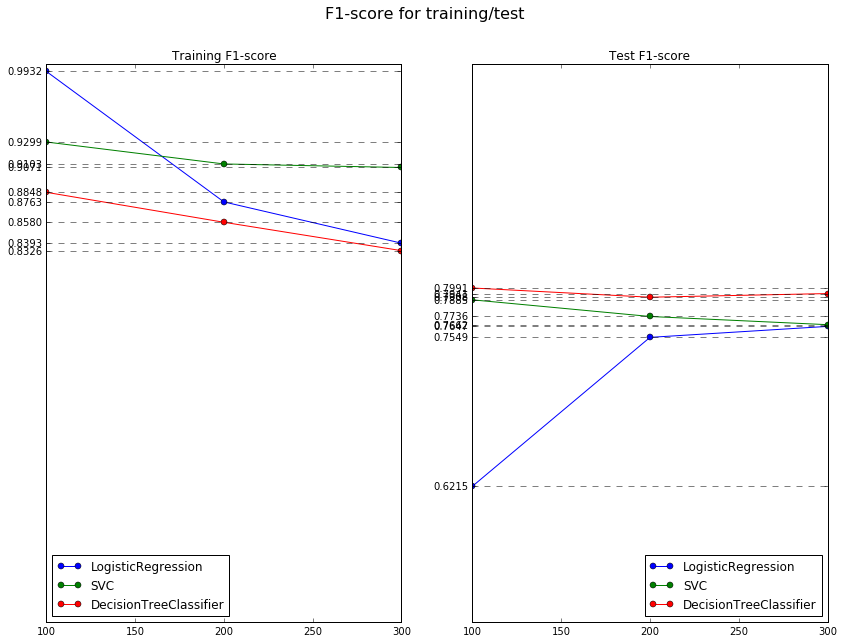

In [146]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict

model_names = list(OrderedDict.fromkeys([x[0] for x in scores]))
X = list(OrderedDict.fromkeys([x[1] for x in scores]))
y1_train = [x[2] for x in scores if x[0] == model_names[0]]
y1_test = [x[3] for x in scores if x[0] == model_names[0]]
y2_train = [x[2] for x in scores if x[0] == model_names[1]]
y2_test = [x[3] for x in scores if x[0] == model_names[1]]
y3_train = [x[2] for x in scores if x[0] == model_names[2]]
y3_test = [x[3] for x in scores if x[0] == model_names[2]]

fig = plt.figure(figsize=(14, 10))
fig.suptitle("F1-score for training/test", fontsize=16)
# major ticks every 100, minor ticks every 25                                      
major_ticks = np.arange(0, 325, 100)                                              
minor_ticks = np.arange(0, 325, 25)                                               

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)

ax.grid(which='both')  
ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.5)  


ax = plt.subplot(121)
ax.set_yticks([x[2] for x in scores])
ax.grid(axis='y', linestyle='--')

ax.plot(X, y1_train, label = model_names[0], marker = 'o')
ax.plot(X, y2_train, label = model_names[1], marker = 'o')
ax.plot(X, y3_train, label = model_names[2], marker = 'o')
ax.set_ylim(ymin=0.5, ymax = 1)
ax.set_title('Training F1-score')
ax.legend(loc='lower left')

ax = plt.subplot(122)
ax.set_yticks([x[3] for x in scores])
ax.grid(axis='y', linestyle='--')

ax.plot(X, y1_test, label = model_names[0], marker = 'o')
ax.plot(X, y2_test, label = model_names[1], marker = 'o')
ax.plot(X, y3_test, label = model_names[2], marker = 'o')
ax.set_ylim(ymin=0.5, ymax = 1)
ax.set_title('Test F1-score')
ax.legend(loc='lower right')

plt.show()

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

In [106]:
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import StratifiedKFold

# we encore the class labels into binary format
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# STEP 1 : we tune the model using grid-search to find optimal hyper-parameters combination
gs = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state=1, criterion='entropy', min_samples_leaf=10),
    param_grid = [
        {'max_depth': [1,2,3,4,5,6,7,8,9,None]}
    ],
    scoring = 'f1',
    cv=StratifiedKFold(y_train, 15)
)

from sklearn.metrics import f1_score
tree = gs.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = f1_score(y_train, y_train_pred)
tree_test = f1_score(y_test, y_test_pred)
print '>>> Decision tree train/test F1-score %.3f/%.3f' % (tree_train, tree_test)

print gs.best_estimator_

# STEP 2 : we use bagging ensemble technique

# A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets 
# of the original dataset and then aggregate their individual predictions (either by voting or by averaging) 
# to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of 
# a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure 
# and then making an ensemble out of it.

# based on the results from the grid we create the optimal classifier
tree = gs.best_estimator_

from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=1000,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = f1_score(y_train, y_train_pred)
bag_test = f1_score(y_test, y_test_pred)
print '>>> Bagging train/test F1-score %.3f/%.3f' % (tree_train, tree_test)

>>> Decision tree train/test F1-score 0.814/0.803
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')
>>> Bagging train/test F1-score 0.814/0.803


In [107]:
from sklearn.tree import export_graphviz
export_graphviz(gs.best_estimator_,
                out_file='tree.dot',
                feature_names=list(X_all.columns))
# Open the tree.dot file with Graphviz